# AMATH 585

# Homework 6

### Shabab Ahmed 



In [1]:
%matplotlib inline

In [2]:
from pylab import *

We add the following code to suppress warning that might appear. 

In [3]:
import logging
logging.captureWarnings(True)

### Animating the iteration

The following piece of code animates figures that comes from the iterations to provide a nice visual way of seeing what is happening for different iterations. 


To use widgets, we set `use_widgets = True`.

In [4]:
use_widgets = True

if use_widgets:
    from ipywidgets import interact
    import ipywidgets as widgets

    def animate_figs(figs):
        show_frame = lambda frameno: display(figs[frameno])
        interact(show_frame, frameno=widgets.IntSlider(min=0,max=len(figs)-1, value=0))
else:
    from jsanimate_figs import animate_figs

# Problem 3b)

Implement the conjugate gradient method for this problem. 
For the convergence test require  $\|r^{[k]}\|_2 < 10^{-14}$.
Allow more than $m$ iterations, if necessary.

Make semilogy plots of the max-norm
of the error and the 2-norm of the residual as a function of iteration $k$
for the case $m=19$ with $\epsilon = 0.1$.  Also try $\epsilon = 10^{-3}$.
You should observe that more than $m$ iterations are required to get good
results.  Comment on the behavior of the iterates in each case.

## Defining kappa, f and the true solution: 

In [5]:
epsilon = 10**(-3)
#epsilon = 0.1
m =19
x_full = linspace(0,1,m+2)
x = x_full[1:m+1] # interior points
h=1/(m+1)
f_fcn = lambda x: 0*x
utrue_fcn = lambda x: piecewise(x, [x < 0.5, x >= 0.5], \
                                [lambda x: (2/(1+epsilon))*x, lambda x: (1/(1+epsilon))*(2*epsilon*x+1-epsilon)])

kappa = lambda x: piecewise(x, [x < 0.5, x >= 0.5], [lambda x: 0*x+epsilon, lambda x: 0*x+1])  

The discretization of $\frac{d}{dx}(\kappa u(x))$ is: 

$$
\frac{1}{h^2}[\kappa_{i+\frac{1}{2}}(U_{i+1}-U_{i}) - \kappa_{i-\frac{1}{2}}(U_i-U_{i-1})] -f(x_i)
$$

In [6]:
x_imh_j = x - h/2.           # x_{i-1\2}
kappa_imh_j = kappa(x_imh_j) # kappa_{i-1/2}

x_iph_j = x + h/2.          # x_{i+1\2}
kappa_iph_j = kappa(x_iph_j) # kappa_{i+1/2}




In [7]:
def matvec(v):
    """
    Given a grid function v on an mx by my grid. 
    Return b = A*v
    """
   
    # pad V with zeros around border, needed for computing centered differences:
    v_full = zeros(m+2)
    v_full[1:-1] = v
    
    # set array B of shape (mx,my) at interior points (same shape as V) 
    # Note that slicing with [1:-1] corresponds to interior points,
    # [:-2] correspond to points to the left (or below) and 
    # [2:] are points to the right (or above)
    
    B =   (kappa_iph_j*(v_full[2:] - v_full[1:-1]) \
         - kappa_imh_j*(v_full[1:-1] - v_full[:-2])) / h**2 
                    
    return B

In [8]:
def solve_bvp_CG(f_fcn, utrue_fcn, maxiter, kplot, verbose=False):
    
    h = 1./(m+1)
   
    

    utrue_full = utrue_fcn(x_full)
    utrue = utrue_full[1:m+1]  # at interior points
    
    # Dirichlet boundary values from true solution:
    alpha = utrue_fcn(0.)
    beta = utrue_fcn(1.)

    f_full = f_fcn(x_full)

    # right-hand side:
    f = f_full[1:m+1]  # at interior points

    # adjust for Dirichlet BCs:
    f[0] = f[0] - (kappa_imh_j[0]*alpha) / h**2
    f[m-1] = f[m-1] - (kappa_iph_j[-1]*beta) / h**2

    # initial guess:
    U0_full = zeros(m+2)  # linear
    U0_full[-1] = 1
    U0 = U0_full[1:m+1]  # interior points
  


    U = U0.copy() # current iterate
    r = f - matvec(U)  # initial residual

    p = r.copy()  # initial direction

    tol = 1e-14  # stop if the residual 

    enorm = abs(U-utrue).max()
    errors = [enorm]
    rTr_k = dot(r,r)
    rnorm = sqrt(rTr_k)
    r2 = [rnorm]
    figs = []  # for the list of figures we generate

    rTr_km = dot(r,r)  # r^T * r at iteration k-1

    for k in range(1,maxiter+1):
        w = matvec(p)   # the only matrix-vector multiply
        a = rTr_km / dot(p,w) # alpha_{k-1} in CG algorithm
        U = U + a*p
        r = r - a*w
    
        
        enorm = abs(U-utrue).max()
        errors.append(enorm)
        

        if mod(k,kplot)==0 or k==maxiter:
            # every kplot iterations create a plot:
            fig = figure(figsize=(12,5))
            plot(x_full,U0_full,'r-o', label='initial guess')
            plot(x_full,utrue_full,'k-o', label='true solution')
            U_full = hstack([alpha,U,beta])
            plot(x_full,U_full,'bo-', label= 'iteration k = %i' % k)
            legend()
            grid(True)
            title('After %i iterations, norm(error) = %.2e' \
                  % (k, enorm))
            figs.append(fig)
            close(fig)

        rTr_k = dot(r,r)
        rnorm = sqrt(rTr_k)
        r2.append(rnorm)
        
        if verbose:
            print('iteration %3i:   2-norm(r) = %.2e,   max-norm(E) = %.2e' \
                  % (k,rnorm,enorm))
        
        if rnorm < tol:
            if verbose: print('Stopping after %i iterations' % k)
            break

        # determine next search direction:
        b = rTr_k / rTr_km   # beta_{k-1} in CG algorithm
        rTr_km = rTr_k       # for next iteration
        p = r + b*p           # next search direction
    return errors, figs, r2

In [9]:
errors,figs, r2 = solve_bvp_CG(f_fcn, utrue_fcn, maxiter=50, kplot=1, verbose=True)

iteration   1:   2-norm(r) = 2.00e+02,   max-norm(E) = 1.00e+00
iteration   2:   2-norm(r) = 1.33e+02,   max-norm(E) = 1.00e+00
iteration   3:   2-norm(r) = 1.00e+02,   max-norm(E) = 1.00e+00
iteration   4:   2-norm(r) = 8.00e+01,   max-norm(E) = 1.00e+00
iteration   5:   2-norm(r) = 6.67e+01,   max-norm(E) = 9.99e-01
iteration   6:   2-norm(r) = 5.71e+01,   max-norm(E) = 9.99e-01
iteration   7:   2-norm(r) = 5.00e+01,   max-norm(E) = 9.99e-01
iteration   8:   2-norm(r) = 4.44e+01,   max-norm(E) = 9.99e-01
iteration   9:   2-norm(r) = 4.00e+01,   max-norm(E) = 9.99e-01
iteration  10:   2-norm(r) = 3.96e-01,   max-norm(E) = 8.99e-01
iteration  11:   2-norm(r) = 1.99e-01,   max-norm(E) = 7.99e-01
iteration  12:   2-norm(r) = 1.33e-01,   max-norm(E) = 6.99e-01
iteration  13:   2-norm(r) = 1.00e-01,   max-norm(E) = 5.99e-01
iteration  14:   2-norm(r) = 9.14e-01,   max-norm(E) = 5.94e-01
iteration  15:   2-norm(r) = 2.50e-01,   max-norm(E) = 4.99e-01
iteration  16:   2-norm(r) = 9.49e-02,  

Text(0.5, 1.0, 'Semilogy plot of max error')

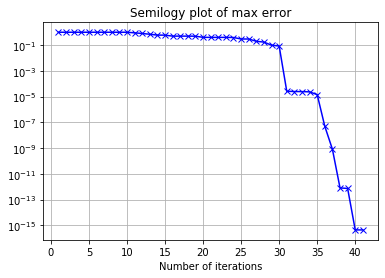

In [10]:
semilogy(range(1,len(errors)+1), errors, 'b-x')
grid(True)
xlabel('Number of iterations')
title('Semilogy plot of max error')



Text(0.5, 0, 'Number of iterations')

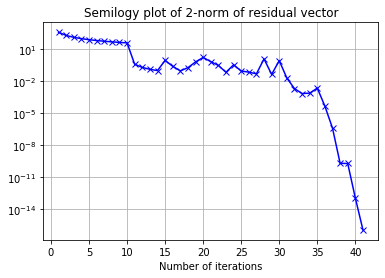

In [11]:
semilogy(range(1,len(r2)+1),r2, 'b-x')
grid(True)
title('Semilogy plot of 2-norm of residual vector')
xlabel('Number of iterations')

In [12]:
animate_figs(figs)

interactive(children=(IntSlider(value=0, description='frameno', max=39), Output()), _dom_classes=('widget-inte…

# Problem 3c)

Implement the preconditioned C-G algorithm (PCG) using the 
diagonal preconditioner and observe that this greatly 
improves the convergence behavior.

----
Here we only consider the simplest (but often effective) preconditioner in which $M$ is the diagonal part of $A$.For the variable coefficient problem this can help a lot, particularly if the values of $\kappa$ vary greatly.

For this problem, where  $A$ that is symmetric *negative* definite, we want to define $M$ based on the absolute values of the diagonal elements.

For this problem the diagonal element of $A$ corresponding to the central coefficient of the 5-point stencil at each grid point , with absolute value is given by

$$
\frac{(\kappa_{i-1/2} + \kappa_{i+1/2})}{h^2}
$$



In [13]:
Mdiag = (kappa_imh_j +kappa_iph_j)/h**2

In [14]:
maxiter = 1000
kplot = 1
verbose = False
tol = 1e-14  # stop if the residual falls below tol


print('using tol = %.2e with maxiter = %i' % (tol,maxiter))

h = 1./(m+1)
x_full = linspace(0,1,m+2)
x = x_full[1:m+1] # interior points
   
    

utrue_full = utrue_fcn(x_full)
utrue = utrue_full[1:m+1]  # at interior points

# Dirichlet boundary values from true solution:
alpha = utrue_fcn(0.)
beta = utrue_fcn(1.)

f_full = f_fcn(x_full)

# right-hand side:
f = f_full[1:m+1]  # at interior points

# adjust for Dirichlet BCs:
f[0] = f[0] - (kappa_imh_j[0]*alpha) / h**2
f[m-1] = f[m-1] - (kappa_iph_j[-1]*beta) / h**2

# initial guess:
U0_full = zeros(m+2)  # linear
U0_full[-1] = 1
U0 = U0_full[1:m+1]  # interior points

U = U0.copy() # current iterate
r = f - matvec(U)  # initial residual
  
z = r / Mdiag  # apply preconditioner

k = 0
zTr_k = dot(z,r)  # modified for PCG
p = z.copy()

enorm = abs(U-utrue).max()
errors = [enorm]
rTr_k = dot(r,r)  # for checking convergence
rnorm = sqrt(rTr_k)
rnorms = [rnorm]  # build up list of residuals

if verbose:
    print('iteration %3i:   2-norm(r) = %.2e,   max-norm(E) = %.2e' \
          % (k,rnorm))
    
figs = []  # for the list of figures we generate


zTr_km = zTr_k  # in general will hold z^T * r at iteration k-1

for k in range(1,maxiter+1):
    w = matvec(p)   # the only matrix-vector multiply
    a = zTr_km / dot(p,w)  # alpha_{k-1} in PCG algorithm
    U = U + a*p
    r = r - a*w
    z = r / Mdiag  # apply preconditioner

    zTr_k = dot(z,r)  # modified for PCG
    
    rTr_k = dot(r,r)  # for checking convergence
    rnorm = sqrt(rTr_k)
    rnorms.append(rnorm)
    enorm = abs(U-utrue).max()
    errors.append(enorm)
    if mod(k,kplot)==0 or k==maxiter:
        # every kplot iterations create a plot:
        fig = figure(figsize=(12,5))
        plot(x_full,U0_full,'r-o', label='initial guess')
        plot(x_full,utrue_full,'k-o', label='true solution')
        U_full = hstack([alpha,U,beta])
        plot(x_full,U_full,'bo-', label= 'iteration k = %i' % k)
        legend()
        grid(True)
        title('After %i iterations, norm(error) = %.2e' \
              % (k, enorm))
        figs.append(fig)
        close(fig)

        
    if verbose:
        print('iteration %3i:   2-norm(r) = %.2e' \
              % (k,rnorm))
    
    # check for convergence:
    if rnorm < tol:
        print('Satisfied rnorm < tol after %i iterations' % k)
        break
        
    # determine next search direction:
    b = zTr_k / zTr_km   # beta_{k-1} in PCG algorithm
    zTr_km = zTr_k       # for next iteration
    p = z + b*p           # next search direction

print('Stopped after %i iterations with 2-norm(r) = %.2e' \
   % (k,rnorm))


using tol = 1.00e-14 with maxiter = 1000
Satisfied rnorm < tol after 20 iterations
Stopped after 20 iterations with 2-norm(r) = 8.58e-15


Text(0.5, 1.0, 'Semilogy plot of max error')

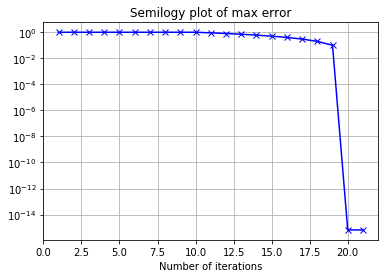

In [15]:
semilogy(range(1,len(errors)+1), errors, 'b-x')
grid(True)
xlabel('Number of iterations')
title('Semilogy plot of max error')


Text(0.5, 0, 'Number of iterations')

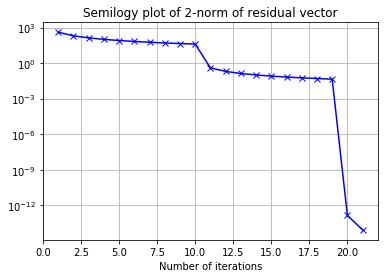

In [16]:
semilogy(range(1,len(rnorms)+1),rnorms, 'b-x')
grid(True)
title('Semilogy plot of 2-norm of residual vector')
xlabel('Number of iterations')

In [17]:
animate_figs(figs)

interactive(children=(IntSlider(value=0, description='frameno', max=19), Output()), _dom_classes=('widget-inte…